# Bayesian linear regression: Parameter estimation

## Bayesian linear regression (1D without bias)

We know the formulation of the simple linear regression for $\mathbf{x}=\{x_1,x_2,..,x_N\}$ and $\mathbf{y}=\{y_1,y_2,..,y_N\}$,
### $$
\mathbf{y} = \theta\mathbf{x} + \boldsymbol{\epsilon}
$$

#### In probabilistic world, we can define the Gaussian distributions over the noise parameter as following,
### $$
\boldsymbol{\epsilon} \sim \mathcal{N}(0, I\sigma_n^2)
$$
### $$p(\mathbf{y}|\theta) \sim \mathcal{N}(\theta\mathbf{x}, I\sigma_n^2)$$

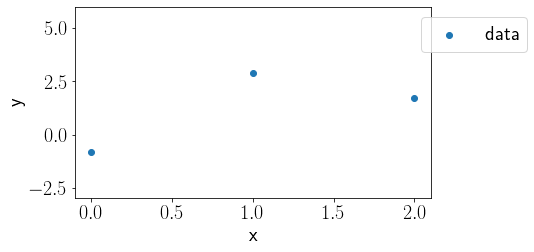

In [60]:
np.random.seed(2)
rc('font',size=20)
plt.figure(figsize=(8,4))
N = 3
x = np.linspace(0,2,N).reshape(-1,1)
t = 3
sigma_n = 2
y = t*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
plt.scatter(x, y, label='data');plt.xlabel('x');plt.ylabel('y');
plt.ylim(-3,6);plt.legend(bbox_to_anchor=(1.3,1));
plt.tight_layout()

Now, we should be able to appreciate the effectiveness of MLE as we can find such $\theta$ so that our likelihood of observing given data $D=\mathbf{y}$ is maximized.

### \begin{aligned}
p(D|\theta) &= \frac{1}{\sqrt{(2\pi)^N}\sigma_n^N}exp\left[-\sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)^2}{2\sigma_n^2}\right] \\
\log p(D|\theta) &= -\frac{N}{2}\log(2\pi\sigma_n^2) - \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)^2}{2\sigma_n^2}\\
argmin -\log p(D|\theta)&= argmin \sum\limits_{i=1}^{N}(y_i - \theta x_i)^2\\
\end{aligned}
This turns out as the same cost function in linear regression.

### \begin{aligned}
\frac{d}{d\theta} \log p(D|\theta) &= \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)x_i}{\sigma_n^2} = 0\\
\theta_{MLE} &= \frac{\sum\limits_{i=1}^{N}y_ix_i}{\sum\limits_{i=1}^{N}x_i^2}
\end{aligned}

### \begin{aligned}
\text{Normal equation }\mathbf{\theta_{opt}} = (X^TX)^{-1}X^Ty
\end{aligned}

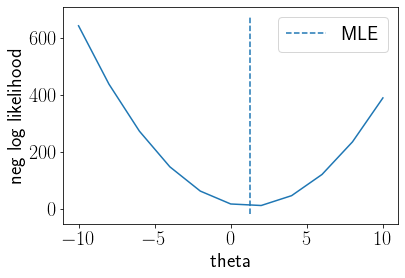

In [61]:
def loglin(t1):
    N = x.shape[0]
    return -(N/2)*jnp.log(2*jnp.pi*sigma_n**2) - jnp.sum(jnp.square(y-t1*x))

T = np.linspace(-10,10,11)
LL = [-loglin(t1) for t1 in T]
fig, ax = plt.subplots()
ax.plot(T, LL);
ax.vlines(np.sum(x*y)/np.sum(np.square(x)),*ax.get_ylim(),linestyle='--',label='MLE')
ax.set_xlabel("theta");ax.set_ylabel("neg log likelihood");
plt.legend(bbox_to_anchor=[1,1]);

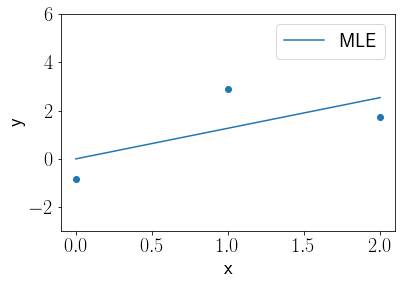

In [62]:
np.random.seed(1)
rc('font',size=20)
plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');
t_mle = np.sum(x*y).squeeze()/np.sum(np.square(x)).squeeze()
plt.plot(x, t_mle*x, label='MLE');plt.ylim(-3,6);
plt.legend();

#### Gradient descent is illustrated below.

In [14]:
costs = []
thetas = []
theta = 10.
lr = 0.02

grad_func = grad(loglin)
for iteration in range(20):
    dt = -grad_func(theta)
    theta = theta - lr*dt
    costs.append(-loglin(theta))
    thetas.append(theta)
rc('font',size=14)
fig,ax = plt.subplots(1,2,figsize=(10,4))
def update(i):
    ax[1].cla();ax[0].cla();
    ax[0].plot(T, LL,color='b')
    ax[0].set_xlabel('theta');ax[0].set_ylabel('neg log likelihood');
    ax[0].scatter(thetas[:i+1], costs[:i+1], label='solution',c='r')
    ax[0].legend()
    ax[1].scatter(x,y)
    ax[1].plot(x, thetas[i]*x, label='estimated fit')
    ax[1].set_xlabel('x');ax[1].set_ylabel('y');
    ax[1].legend()
    ax[1].set_ylim(-5,16);
    plt.tight_layout()
# plt.tight_layout()
plt.close()
anim = FuncAnimation(fig, update, range(20))
anim

<Figure size 432x288 with 0 Axes>

## MAP for linear regression

For linear regression problem, let us assume our theta as a Gaussian distribution beucase our likelihood is Gaussian.

\begin{align}
p(\theta) \sim \mathcal{N}(0,\sigma^2)
\end{align}

In [19]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
np.random.seed(2)
N = 3
x = np.linspace(0,2,N).reshape(-1,1)
t = 3
sigma_n = 2
y = t*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
sigma = 1
samples = np.random.normal(0,sigma,size=10)
thetap = np.linspace(-2,2,20)
def update(i):
    for axs in ax:
        axs.cla()
    ax[0].plot(thetap, GaussianPDF(0, sigma, thetap))
    ax[0].set_xlabel('theta');ax[0].set_ylabel('pdf');
    ax[0].scatter(samples[i], GaussianPDF(0, sigma, samples[i]), label='sample')
    ax[0].legend()
    ax[1].scatter(x,y)
    ax[1].plot(x, samples[i]*x, label='prior fit')
    ax[1].set_xlabel('x');ax[1].set_ylabel('y');
    ax[1].legend()
    ax[1].set_ylim(-4,16);
    ax[0].set_xlim(-2,2);
#     plt.tight_layout()
plt.tight_layout()
plt.close()
anim = FuncAnimation(fig, update, range(10))
anim

Now, we will find MAP estimate incorporating the prior.

\begin{aligned}
p(\theta|D) \propto p(D|\theta)p(\theta) &= \frac{1}{\sqrt{(2\pi)^N}\sigma_n^N}exp\left[-\frac{1}{2}(\mathbf{y}-\theta\mathbf{x})^T(I\sigma_n^2)^{-1}(\mathbf{y}-\theta\mathbf{x})\right] \frac{1}{\sqrt{2\pi\sigma^2}}exp\left[{-\frac{(\theta-0)^2}{2\sigma^2}}\right]
\\
\log [p(D|\theta)p(\theta)] &= -\frac{N}{2}\log(2\pi\sigma_n^2) - \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)^2}{2\sigma_n^2} - \frac{1}{2}\log(2\pi\sigma^2)-\frac{\theta^2}{2\sigma^2}\\
\frac{d}{d\theta}\log [p(D|\theta)p(\theta)] &=  \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)x_i}{\sigma_n^2} - \frac{\theta}{\sigma^2} = 0\\
\theta_{MAP} &= \frac{\sum\limits_{i=1}^{N}y_ix_i}{\sum\limits_{i=1}^{N}x_i^2 + \frac{\sigma_n^2}{\sigma^2}}
\end{aligned}

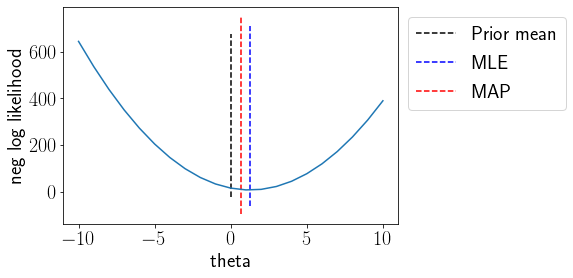

In [20]:
def loglin(t1):
    N = x.shape[0]
    return -(N/2)*jnp.log(2*jnp.pi*sigma_n**2) - jnp.sum(jnp.square(y-t1*x))

T = np.linspace(-10,10,21)
LL = [-loglin(t1) for t1 in T]
fig, ax = plt.subplots()
ax.plot(T, LL);
ax.vlines(0,*ax.get_ylim(),linestyle='--',label='Prior mean',color='k')
ax.vlines(np.sum(x*y)/np.sum(np.square(x)),*ax.get_ylim(),linestyle='--',label='MLE',color='b')
ax.vlines(np.sum(x*y)/(np.sum(np.square(x))+(sigma_n**2/sigma**2)),*ax.get_ylim(),linestyle='--',label='MAP',color='r')
ax.set_xlabel("theta");ax.set_ylabel("neg log likelihood");
plt.legend(bbox_to_anchor=[1,1]);

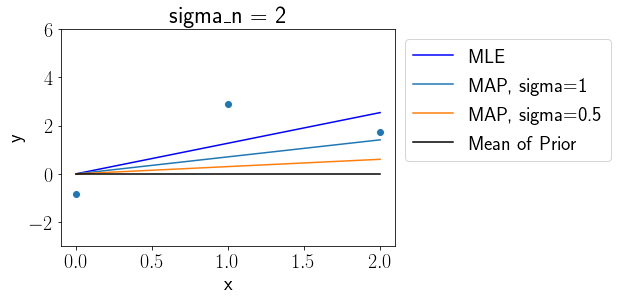

In [21]:
np.random.seed(1)
rc('font',size=20)
plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');
t_mle = np.sum(x*y)/np.sum(np.square(x))
plt.plot(x, t_mle*x, label='MLE', color='b')
t_map = np.sum(x*y)/(np.sum(np.square(x))+(sigma_n**2/sigma**2))
plt.plot(x, t_map*x, label=f'MAP, sigma={sigma}')
t_map = np.sum(x*y)/(np.sum(np.square(x))+(sigma_n**2/0.5**2))
plt.plot(x, t_map*x, label=f'MAP, sigma={0.5}')
plt.plot(x, 0*x, label='Mean of Prior', color='k')
plt.ylim(-3,6);
plt.legend(bbox_to_anchor=(1,1));
plt.title(f'sigma\_n = {sigma_n}');

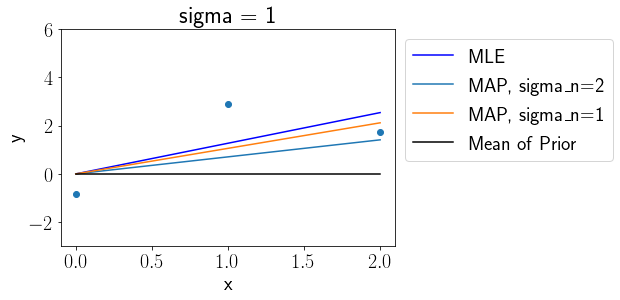

In [22]:
np.random.seed(1)
rc('font',size=20)
plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');
t_mle = np.sum(x*y)/np.sum(np.square(x))
plt.plot(x, t_mle*x, label='MLE',color='b')
t_map = np.sum(x*y)/(np.sum(np.square(x))+(sigma_n**2/sigma**2))
plt.plot(x, t_map*x, label=f'MAP, sigma\_n={sigma_n}')
t_map = np.sum(x*y)/(np.sum(np.square(x))+(1**2/1**2))
plt.plot(x, t_map*x, label=f'MAP, sigma\_n={1}')
plt.plot(x, 0*x, label='Mean of Prior', color='k')
plt.ylim(-3,6);
plt.legend(bbox_to_anchor=(1,1));
plt.title(f'sigma = {sigma}');

### Bayesian linear regression (1D with bias term)

Now, we will programatically explore MLE and MAP for 1D linear regression after including the bias term.

\begin{aligned}
\mathbf{\theta}_{MLE} &= (X^TX)^{-1}X^T\mathbf{y}\\
\\
\mathbf{\theta}_{MAP} &= (X^TX + I\frac{\sigma_n^2}{\sigma^2})^{-1}X^T\mathbf{y}
\end{aligned}

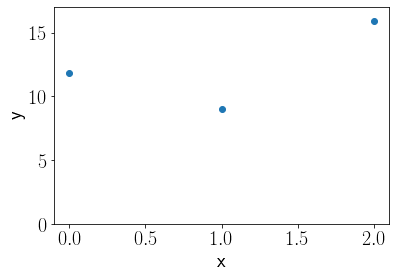

In [67]:
np.random.seed(0)
N = 3
x = np.linspace(0,2,N).reshape(-1,1)
sigma_n = 2
rc('font',size=20)
t0, t1 = 3, 4
sigma_n = 5
y = t0 + t1*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
plt.ylim(0,17)
plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');

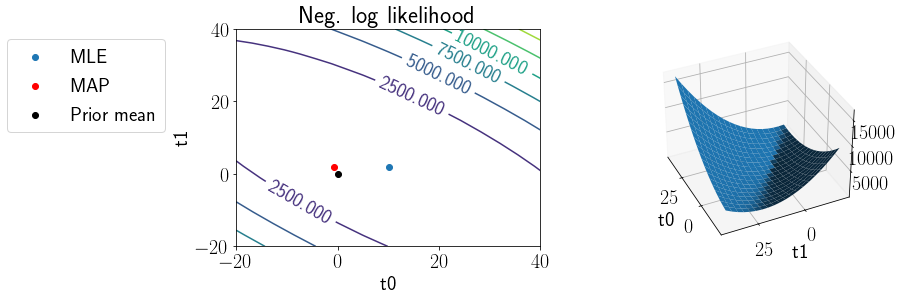

In [24]:
def LogLin2D(t0, t1):
    N = x.shape[0]
    return (N/2)*jnp.log(2*jnp.pi*sigma_n**2) + jnp.sum(jnp.square(y-t0-t1*x))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)

T0, T1 = np.meshgrid(np.linspace(-20,40,20), np.linspace(-20,40,20))
Z = np.array([LogLin2D(t00, t11) for t00, t11 in zip(T0.ravel(), T1.ravel())]).reshape(*T0.shape)
mp = ax.contour(T0, T1, Z);
plt.clabel(mp);
ax.set_xlabel('t0');ax.set_ylabel('t1');
ax.set_title('Neg. log likelihood');
x_extra = np.hstack([np.ones((x.shape[0], 1)), x])
t0_mle, t1_mle = np.linalg.inv(x_extra.T@x_extra)@x_extra.T@y
t0_map, t1_map = np.linalg.inv(x_extra.T@x_extra + np.eye(x.shape[1])*(sigma_n**2/sigma**2))@x_extra.T@y
# ax.annotate('GT', (t0, t1))
ax.scatter(t0_mle, t1_mle, label='MLE');
# ax.annotate('MLE', (t0_mle, t1_mle))
ax.scatter(t0_map, t1_map, label='MAP',c='r');
# ax.annotate('MAP', (t0_map, t1_map))
ax.scatter(0, 0, label='Prior mean',c='k');
# ax.text(-4,0, 'Prior mean')
ax.legend(bbox_to_anchor=(-0.2,1))

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(T0, T1, Z);
ax.view_init(35, 90+65);
ax.set_xlabel('t0');ax.set_ylabel('t1');

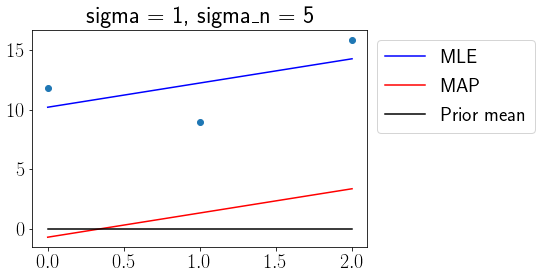

In [25]:
plt.scatter(x,y);
plt.plot(x, t0_mle+t1_mle*x, label='MLE',color='b')
plt.plot(x, t0_map+t1_map*x, label='MAP',color='r')
plt.plot(x, 0*x, label='Prior mean',color='k')
plt.title(f'sigma = {sigma}, sigma\_n = {sigma_n}')
plt.legend(bbox_to_anchor=(1,1));

### Another case

In [69]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133, projection='3d')
sigma, sigma_n = 1, 2
def update(N):
    ax.cla();ax1.cla();ax2.cla()
    np.random.seed(1)
    x = np.linspace(0,2,N).reshape(-1,1)
    y = t0 + t1*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
    x_extra = np.hstack([np.ones((x.shape[0], 1)), x])
    t0_mle, t1_mle = np.linalg.inv(x_extra.T@x_extra)@x_extra.T@y
    t0_map, t1_map = np.linalg.inv(x_extra.T@x_extra + np.eye(x.shape[1])*(sigma_n**2/sigma**2))@x_extra.T@y

    ax.scatter(x,y);
    ax.plot(x, t0_mle+t1_mle*x, label='MLE',color='b')
    ax.plot(x, t0_map+t1_map*x, label='MAP',color='r')
    ax.plot(x, 0*x, label='Prior mean',color='k')
    ax.set_ylim(-1,15)
    ax.set_title(f'sigma = {sigma}, sigma\_n = {sigma_n}')
    ax.legend(loc='upper left');
    ax.set_xlabel('x');ax.set_ylabel('y')
    
    T0, T1 = np.meshgrid(np.linspace(-10,10,50), np.linspace(-10,10,50))
    Z = np.array([LogLin2D(t00, t11) for t00, t11 in zip(T0.ravel(), T1.ravel())]).reshape(*T0.shape)
    mp = ax1.contour(T0, T1, Z, levels=15);
    ax.clabel(mp);
    ax1.scatter(t0_mle, t1_mle, label='MLE', c='b',marker='d',s=100);
    # ax.annotate('MLE', (t0_mle, t1_mle))
    ax1.scatter(t0_map, t1_map, label='MAP', c='r',marker='*',s=100);
    # ax.annotate('MAP', (t0_map, t1_map))
    ax1.scatter(0, 0, label='Prior mean',c='k',marker='o',s=100);
    ax1.set_xlabel('$\\theta_0$');ax1.set_ylabel('$\\theta_1$',labelpad=-12);
    ax1.set_title('Neg. log likelihood');
    
    ax2.contour3D(T0, T1, Z, levels=40);
    ax2.scatter(t0_mle, t1_mle, label='MLE', c='b');
    # ax.annotate('MLE', (t0_mle, t1_mle))
    ax2.scatter(t0_map, t1_map, label='MAP', c='r');
    # ax.annotate('MAP', (t0_map, t1_map))
    ax2.scatter(0, 0, label='Prior mean',c='k');
    ax2.view_init(35, 15+90);
    ax2.set_xlabel('$\\theta_0$');ax2.set_ylabel('$\\theta_1$');
    
    plt.tight_layout()
plt.close()
anim = FuncAnimation(fig, update, range(2,21))
anim

<Figure size 432x288 with 0 Axes>

In [ ]:
## MAP for linear regression

For linear regression problem, let us assume our theta as a Gaussian distribution beucase our likelihood is Gaussian.

\begin{align}
p(\theta) \sim \mathcal{N}(0,\sigma^2)
\end{align}

fig,ax = plt.subplots(1,2,figsize=(10,4))
np.random.seed(2)
N = 3
x = np.linspace(0,2,N).reshape(-1,1)
t = 3
sigma_n = 2
y = t*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
sigma = 1
samples = np.random.normal(0,sigma,size=10)
thetap = np.linspace(-2,2,20)
def update(i):
    for axs in ax:
        axs.cla()
    ax[0].plot(thetap, GaussianPDF(0, sigma, thetap))
    ax[0].set_xlabel('theta');ax[0].set_ylabel('pdf');
    ax[0].scatter(samples[i], GaussianPDF(0, sigma, samples[i]), label='sample')
    ax[0].legend()
    ax[1].scatter(x,y)
    ax[1].plot(x, samples[i]*x, label='prior fit')
    ax[1].set_xlabel('x');ax[1].set_ylabel('y');
    ax[1].legend()
    ax[1].set_ylim(-4,16);
    ax[0].set_xlim(-2,2);
#     plt.tight_layout()
plt.tight_layout()
plt.close()
anim = FuncAnimation(fig, update, range(10))
anim

Now, we will find MAP estimate incorporating the prior.

\begin{aligned}
p(\theta|D) \propto p(D|\theta)p(\theta) &= \frac{1}{\sqrt{(2\pi)^N}\sigma_n^N}exp\left[-\frac{1}{2}(\mathbf{y}-\theta\mathbf{x})^T(I\sigma_n^2)^{-1}(\mathbf{y}-\theta\mathbf{x})\right] \frac{1}{\sqrt{2\pi\sigma^2}}exp\left[{-\frac{(\theta-0)^2}{2\sigma^2}}\right]
\\
\log [p(D|\theta)p(\theta)] &= -\frac{N}{2}\log(2\pi\sigma_n^2) - \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)^2}{2\sigma_n^2} - \frac{1}{2}\log(2\pi\sigma^2)-\frac{\theta^2}{2\sigma^2}\\
\frac{d}{d\theta}\log [p(D|\theta)p(\theta)] &=  \sum\limits_{i=1}^{N}\frac{(y_i - \theta x_i)x_i}{\sigma_n^2} - \frac{\theta}{\sigma^2} = 0\\
\theta_{MAP} &= \frac{\sum\limits_{i=1}^{N}y_ix_i}{\sum\limits_{i=1}^{N}x_i^2 + \frac{\sigma_n^2}{\sigma^2}}
\end{aligned}

def loglin(t1):
    N = x.shape[0]
    return -(N/2)*jnp.log(2*jnp.pi*sigma_n**2) - jnp.sum(jnp.square(y-t1*x))

T = np.linspace(-10,10,21)
LL = [-loglin(t1) for t1 in T]
fig, ax = plt.subplots()
ax.plot(T, LL);
ax.vlines(0,*ax.get_ylim(),linestyle='--',label='Prior mean',color='k')
ax.vlines(np.sum(x*y)/np.sum(np.square(x)),*ax.get_ylim(),linestyle='--',label='MLE',color='b')
ax.vlines(np.sum(x*y)/(np.sum(np.square(x))+(sigma_n**2/sigma**2)),*ax.get_ylim(),linestyle='--',label='MAP',color='r')
ax.set_xlabel("theta");ax.set_ylabel("neg log likelihood");
plt.legend(bbox_to_anchor=[1,1]);

np.random.seed(1)
rc('font',size=20)
plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');
t_mle = np.sum(x*y)/np.sum(np.square(x))
plt.plot(x, t_mle*x, label='MLE', color='b')
t_map = np.sum(x*y)/(np.sum(np.square(x))+(sigma_n**2/sigma**2))
plt.plot(x, t_map*x, label=f'MAP, sigma={sigma}')
t_map = np.sum(x*y)/(np.sum(np.square(x))+(sigma_n**2/0.5**2))
plt.plot(x, t_map*x, label=f'MAP, sigma={0.5}')
plt.plot(x, 0*x, label='Mean of Prior', color='k')
plt.ylim(-3,6);
plt.legend(bbox_to_anchor=(1,1));
plt.title(f'sigma\_n = {sigma_n}');

np.random.seed(1)
rc('font',size=20)
plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');
t_mle = np.sum(x*y)/np.sum(np.square(x))
plt.plot(x, t_mle*x, label='MLE',color='b')
t_map = np.sum(x*y)/(np.sum(np.square(x))+(sigma_n**2/sigma**2))
plt.plot(x, t_map*x, label=f'MAP, sigma\_n={sigma_n}')
t_map = np.sum(x*y)/(np.sum(np.square(x))+(1**2/1**2))
plt.plot(x, t_map*x, label=f'MAP, sigma\_n={1}')
plt.plot(x, 0*x, label='Mean of Prior', color='k')
plt.ylim(-3,6);
plt.legend(bbox_to_anchor=(1,1));
plt.title(f'sigma = {sigma}');

### Bayesian linear regression (1D with bias term)

Now, we will programatically explore MLE and MAP for 1D linear regression after including the bias term.

\begin{aligned}
\mathbf{\theta}_{MLE} &= (X^TX)^{-1}X^T\mathbf{y}\\
\\
\mathbf{\theta}_{MAP} &= (X^TX + I\frac{\sigma_n^2}{\sigma^2})^{-1}X^T\mathbf{y}
\end{aligned}

np.random.seed(0)
N = 3
x = np.linspace(0,2,N).reshape(-1,1)
sigma_n = 2
rc('font',size=20)
t0, t1 = 3, 4
sigma_n = 5
y = t0 + t1*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
plt.ylim(0,17)
plt.scatter(x, y);plt.xlabel('x');plt.ylabel('y');

def LogLin2D(t0, t1):
    N = x.shape[0]
    return (N/2)*jnp.log(2*jnp.pi*sigma_n**2) + jnp.sum(jnp.square(y-t0-t1*x))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)

T0, T1 = np.meshgrid(np.linspace(-20,40,20), np.linspace(-20,40,20))
Z = np.array([LogLin2D(t00, t11) for t00, t11 in zip(T0.ravel(), T1.ravel())]).reshape(*T0.shape)
mp = ax.contour(T0, T1, Z);
plt.clabel(mp);
ax.set_xlabel('t0');ax.set_ylabel('t1');
ax.set_title('Neg. log likelihood');
x_extra = np.hstack([np.ones((x.shape[0], 1)), x])
t0_mle, t1_mle = np.linalg.inv(x_extra.T@x_extra)@x_extra.T@y
t0_map, t1_map = np.linalg.inv(x_extra.T@x_extra + np.eye(x.shape[1])*(sigma_n**2/sigma**2))@x_extra.T@y
# ax.annotate('GT', (t0, t1))
ax.scatter(t0_mle, t1_mle, label='MLE');
# ax.annotate('MLE', (t0_mle, t1_mle))
ax.scatter(t0_map, t1_map, label='MAP',c='r');
# ax.annotate('MAP', (t0_map, t1_map))
ax.scatter(0, 0, label='Prior mean',c='k');
# ax.text(-4,0, 'Prior mean')
ax.legend(bbox_to_anchor=(-0.2,1))

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(T0, T1, Z);
ax.view_init(35, 90+65);
ax.set_xlabel('t0');ax.set_ylabel('t1');

plt.scatter(x,y);
plt.plot(x, t0_mle+t1_mle*x, label='MLE',color='b')
plt.plot(x, t0_map+t1_map*x, label='MAP',color='r')
plt.plot(x, 0*x, label='Prior mean',color='k')
plt.title(f'sigma = {sigma}, sigma\_n = {sigma_n}')
plt.legend(bbox_to_anchor=(1,1));

### Another case

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
ax2 = fig.add_subplot(133, projection='3d')
sigma, sigma_n = 1, 2
def update(N):
    ax.cla();ax1.cla();ax2.cla()
    np.random.seed(1)
    x = np.linspace(0,2,N).reshape(-1,1)
    y = t0 + t1*x + np.random.multivariate_normal(np.zeros(N), np.eye(N)*sigma_n**2).reshape(-1,1)
    x_extra = np.hstack([np.ones((x.shape[0], 1)), x])
    t0_mle, t1_mle = np.linalg.inv(x_extra.T@x_extra)@x_extra.T@y
    t0_map, t1_map = np.linalg.inv(x_extra.T@x_extra + np.eye(x.shape[1])*(sigma_n**2/sigma**2))@x_extra.T@y

    ax.scatter(x,y);
    ax.plot(x, t0_mle+t1_mle*x, label='MLE',color='b')
    ax.plot(x, t0_map+t1_map*x, label='MAP',color='r')
    ax.plot(x, 0*x, label='Prior mean',color='k')
    ax.set_ylim(-1,15)
    ax.set_title(f'sigma = {sigma}, sigma\_n = {sigma_n}')
    ax.legend(loc='upper left');
    ax.set_xlabel('x');ax.set_ylabel('y')
    
    T0, T1 = np.meshgrid(np.linspace(-10,10,50), np.linspace(-10,10,50))
    Z = np.array([LogLin2D(t00, t11) for t00, t11 in zip(T0.ravel(), T1.ravel())]).reshape(*T0.shape)
    mp = ax1.contour(T0, T1, Z, levels=15);
    ax.clabel(mp);
    ax1.scatter(t0_mle, t1_mle, label='MLE', c='b',marker='d',s=100);
    # ax.annotate('MLE', (t0_mle, t1_mle))
    ax1.scatter(t0_map, t1_map, label='MAP', c='r',marker='*',s=100);
    # ax.annotate('MAP', (t0_map, t1_map))
    ax1.scatter(0, 0, label='Prior mean',c='k',marker='o',s=100);
    ax1.set_xlabel('$\\theta_0$');ax1.set_ylabel('$\\theta_1$',labelpad=-12);
    ax1.set_title('Neg. log likelihood');
    
    ax2.contour3D(T0, T1, Z, levels=40);
    ax2.scatter(t0_mle, t1_mle, label='MLE', c='b');
    # ax.annotate('MLE', (t0_mle, t1_mle))
    ax2.scatter(t0_map, t1_map, label='MAP', c='r');
    # ax.annotate('MAP', (t0_map, t1_map))
    ax2.scatter(0, 0, label='Prior mean',c='k');
    ax2.view_init(35, 15+90);
    ax2.set_xlabel('$\\theta_0$');ax2.set_ylabel('$\\theta_1$');
    
    plt.tight_layout()
plt.close()
anim = FuncAnimation(fig, update, range(2,21))
anim